#### CSCE 489 :: Recommender Systems :: Texas A&M University :: Spring 2021


# Homework 3: Matrix Factorization

### 100 points [10% of your final grade]

- **Due Friday, March 26 by 11:59pm**

*Goals of this homework:* The objective of this homework is to turn the theory of matrix factorization into practice, and compare the results with your naive non-personalized recommendation from Homework 1, and neighborhood-based collaborative filtering algorithms from Homework 2 to see how matrix factorization model provides better recommendations for both the rating prediction task (with explicit feedback) and the ranking task (with implicit feedback).

*Submission instructions (Canvas):* To submit your homework, rename this notebook as `UIN_hw3.ipynb`. For example, if your UIN is `123456789`, then your homework submission would be `123456789_hw3.ipynb`. Submit this notebook via Canvas. Your notebook should be completely self-contained, with the results visible in the notebook. We should not have to run any code from the command line, nor should we have to run your code within the notebook (though we reserve the right to do so). So please run all the cells for us, and then submit. 

*Late policy:* You may use up to three of your late days on this assignment. No homeworks will be accepted after March 29 11:59pm.

## Collaboration Declaration:

***You must add all of your collaboration declarations here. Who did you talk to about this assignment? What web resources did you use? Etc.***

For example:
* Part 1a: I talked to Amy about how to split the data randomly. She helped me understand that I needed to use a random number generator.
* Part 1b: I needed help on how to comment my code, so I relied on this StackOverflow thread: https://stackoverflow.com/questions/184618/what-is-the-best-comment-in-source-code-you-have-ever-encountered
* (Replace this bullet list with your own collaboration declarations.)


# Part 1. Recommendations with User Ratings (Explicit Feedback) (80 points total)

In this first part, similar to Part 1 in our Homework 1 and Homework 2, we still focus on the rating prediction recommendation task with explicit feedback. But in this part, you will need to build a **matrix factorization** model. You will also evaluate your matrix factorization model to compare with the non-personalized one in Homework 1 and neighborhood-based collaborative filtering models in Homework 2. You may refer to our homework sample solutions for the previous homeworks in case you had trouble with them before.

For this part, we will:

* load and process the MovieLens 1M dataset, 
* build a matrix factorization model,
* tune three hyper-parameters of the matrix factorization model: training epoch, latent dimension and regularization weight,

Before you start to build your recommendation models. First, we need to load and preprocess the experimental dataset. We still use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this homework, and use the same loading and preprocessing process as Homework 2. The code has been provided in the next cell, and you need to run it. The resulting data variables are the same as those in Homework 1: train_mat is the numpy array variable for training data of size (#users, #items) with non-zero entries representing user-item ratings, and zero entries representing unknown user-item ratings; and test_mat is the numpy array variable for testing data of size (#users, #items).

In [43]:
from numpy import asarray
from numpy import save
from numpy import load
import pickle

In [45]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

data_df = pd.read_csv('./filtered_ratings.csv', sep=',', names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(data_df)) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

# generate train_mat and test_mat
num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()

In [46]:
train_mat

array([[3. , 3. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 3. , 0.5, 0. ]])

## Part 1a: Build the Matrix Factorization Model (50 points)

First, let's implement the matrix factorization (MF for short) model introduced in class. The MF model can be mathematically represented as: 

<center>$\underset{\mathbf{P},\mathbf{Q}}{\text{min}}\,\,L=\sum_{(u,i)\in\mathcal{O}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\mathcal{O}$ is a user-movie pair set containing all user-movie pairs having ratings in train_mat; $r_{u,i}$ represents the rating for user u and movie i; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training an MF model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to minimize the loss L.

To implement such an MF, here we will write a Python class for the model. There are three functions in this MF class: init, train, and predict. 

* The 'init' function (**already provided**) is to initialize the variables the MF class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the MF model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the MF formulation.

* The 'train' function (**partially provided and need to complete**) is to train the MF model given the training data train_mat. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs having ratings in train_mat)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight.</center>
        
        3. After iterating over all user-movie pairs, we have finished the training for the current epoch. Now calculate and print out the value of the loss function L after this epoch, and the RMSE on test_mat by the current MF model. Then append them to lists to keep a record of them.
The train function needs to return two lists: 'epoch_loss_list' recording the loss after each training epoch, and 'epoch_test_RMSE_list' recording the RMSE on test_mat after each training epoch.

* The 'predict' function (**already provided**) is to calculate the prediction_mat by the learned $\mathbf{P}$ and $\mathbf{Q}$.


In the next cell, we provide the 'init' and 'predict' functions. You will need to fill in the 'train' function based on the description above. 

**NOTE that you should not delete or modify the provided code.**

In [47]:
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized

    def train(self, epoch=20, verbose=True):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch 
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        epoch_loss_list = []
        epoch_test_RMSE_list = []
        for ep in range(epoch):
            """ 
            Write your code here to implement the training process for one epoch, 
            and at the end of each epoch, print out the epoch number, the training loss after this epoch, 
            and the test RMSE after this epoch
            """
            training_indices = np.arange(self.num_sample)
            np.random.shuffle(training_indices)  # randomly shuffle the training samples
            ratings = self.train_mat[self.sample_user, self.sample_movie]
            for idx in training_indices:
                u = self.sample_user[idx]
                i = self.sample_movie[idx]
                rating = ratings[idx]
                p_u = self.P[u, :]
                q_i = self.Q[i, :]
                prediction = np.matmul(p_u, q_i.T)
                error = prediction - rating
                gradient_P = 2. * error * q_i + 2. * self.reg * p_u
                gradient_Q = 2. * error * p_u + 2. * self.reg * q_i
                self.P[u, :] -= self.lr * gradient_P
                self.Q[i, :] -= self.lr * gradient_Q
            prediction_mat = np.matmul(self.P, self.Q.T)
            
            epoch_loss = np.sum(np.square(prediction_mat * self.train_indicator_mat - self.train_mat)) / np.sum(self.train_indicator_mat)
            epoch_loss += self.reg * (np.sum(self.P ** 2) + np.sum(self.Q ** 2))
            epoch_loss_list.append(epoch_loss)
            
            test_rmse = (np.sum(((prediction_mat - self.test_mat) * self.test_indicator_mat) ** 2) / np.sum(self.test_indicator_mat)) ** 0.5
            epoch_test_RMSE_list.append(test_rmse)
            if verbose:
                print('Epoch={0}, Training Loss={1}, Testing RMSE={2}'.format(ep + 1, epoch_loss, test_rmse))
            """
            End of your code for this function
            """
        return epoch_loss_list, epoch_test_RMSE_list
        
        
    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

Now, let's train an MF model based on your implementation. The code is provided, you just need to excute the next cell. The expectations are: 

* first, the code can be successfully excuted without error; 
* and second, the training loss and RMSE on **test_mat** of each training epoch should be printed out for all 20 epochs.


* Hint: the expected time used for training is around 10s to 60s per training epoch.

In [7]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch=1, Training Loss=58.48069149411628, Testing RMSE=1.0277148397798959


KeyboardInterrupt: 

## Part 1b: Tune Hyper-parameters in Matrix Factorization (30 points)

In Part 1a, we train an MF model with latent dimension set as 5, regularization weight as 0.001, training epoch as 20. However, it is not clear whether these are good choices or not. Hence, in this part, we will tune these hyper-parameters to train an effective model.

A most straightforward but powerful method is to grid search each hyper-parameter and find the best one based on the RMSE on test_mat. In this part, we will do the grid search for train epoch, latent dimension, and regularization weight.

#### Tune training epoch####

For training epoch, we only need to run the experiment of MF for one time, and record the test RMSE for each epoch and find the epoch that produces the best test RMSE. To visually show the change of test RMSE corresponding to the training epoch, we can plot the test RMSE for each epoch in a figure as shown in the next cell.

**Note that you need to first install the matplotlib, then you can excute the next cell**

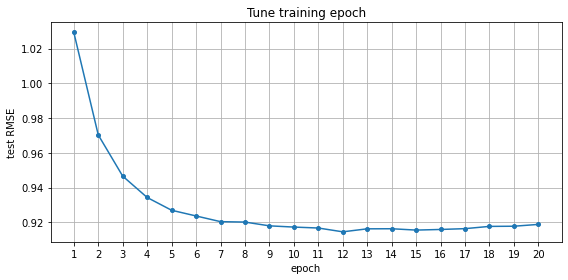

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('Tune training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, what is the best epoch for your MF model?

Write your answer here.

#### Tune latent dimension####

By this figure, you can find the best epoch for your MF model. Similarly, you can plot how the test RMSE changes when you set different latent dimensions. For this, you need to run the code to initialize and train the MF model for multiple times with different settings of 'latent'. Please run the MF model with 'latent' as {1,3,5,7,9}, and plot the corresponding test RMSE for these five different latent dimensions in the next cell. 

**Note that for these five runs of experiments, record the test RMSE after E training epochs -- E is the best epoch you find by the 'Tune training epoch' plot. And here, fix regularization weight as 0.001**.

**Note that the expected output of the next cell is just the plot, you don't need to show the code and printing of the experiment with different 'latent' here.**

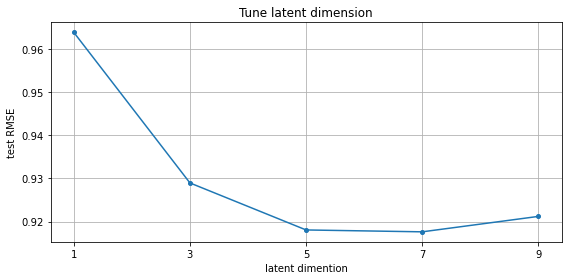

In [12]:
# Your Code Here...
test_rmse_list = []
for latent in [1,3,5,7,9]:
    mf = MF(train_mat, test_mat, latent=latent, lr=0.01, reg=0.001)
    _, epoch_test_RMSE_list = mf.train(epoch=20, verbose=False)
    test_rmse_list.append(epoch_test_RMSE_list[-1])
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot([1,3,5,7,9], test_rmse_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks([1,3,5,7,9])
ax.set_ylabel('test RMSE')
ax.set_xlabel('latent dimention')
ax.set_title('Tune latent dimension')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, what is the best latent dimension for your MF model?

Write your answer here.

#### Tune regularization weight####

Last, you can plot how the test RMSE changes when you set different regularization weight. Please run the MF model with 'reg' as {0.0001,0.0005,0.001,0.0015,0.002}, and plot corresponding test RMSE for these five different regularization weights in the next cell. 

**Note that for these five runs of experiments, record the test RMSE after E training epochs -- E is the best epoch you find by the 'Tune training epoch' plot. And here, fix latent dimension as the one you find the best by the previous part**

**Note that the expected output of the next cell is just the plot, you don't need to show the code and printing of the experiment with different 'reg' here.**

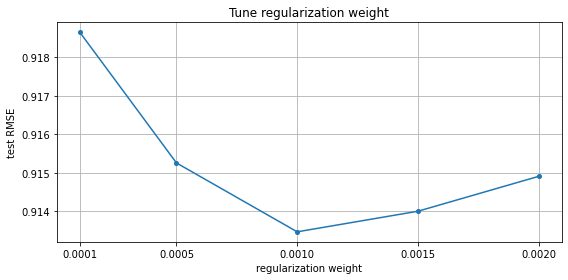

In [13]:
# Your Code Here...
test_rmse_list = []
for reg in [0.0001,0.0005,0.001,0.0015,0.002]:
    mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=reg)
    _, epoch_test_RMSE_list = mf.train(epoch=20, verbose=False)
    test_rmse_list.append(epoch_test_RMSE_list[-1])
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot([0.0001,0.0005,0.001,0.0015,0.002], test_rmse_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks([0.0001,0.0005,0.001,0.0015,0.002])
ax.set_ylabel('test RMSE')
ax.set_xlabel('regularization weight')
ax.set_title('Tune regularization weight')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, what is the best regularization weight for your MF model?

*Write your answer here*

# Part 2. Recommendations with implicit feedback (20 points total)

### Pay special attention to the points allocated for each part. Part 2 is quite involved and should take considerable time. It is also a bit challenging, so we are only assigning 20 points here.

Now we turn to study how matrix factorization algorithms works for recommendations with implicit feedback. The overall pipeline is the same as in Part 2 of Homework 1 and Homework 2. But now you need to implement a matrix factorization algorithm for recommendation.

In this part, you will use the same MovieLens 1M dataset, and:
* write the code to implement a matrix factorization algorithm,
* and evaluate your recommender.

Before the algorithm implementation, we need to first transfer the explicit datasets you already generated to implicit ones. The process is the same as Part 2 in Homework 2, and the code has been provided. You need to run the code in the next cell.

In [48]:
train_mat = (train_mat > 2.0).astype(float)
test_mat = (test_mat > 2.0).astype(float)

Then, you need to write code to implement a matrix factorization algorithm. Although we have not discussed in class how to use matrix factorization algorithm for implicit feedback, it is quite straightforward. The main idea is the same as the MF model for explicit ratings as you aleady implemented in Part 1. But instead of predicting explicit ratings, here the MF is to predict binary ratings based on which movies are ranked for users.

The only challenge now is that in an implicit feedback dataset, there is only positive signal (i.e., '1' in the train_mat) without negative signal. Hence, to let our MF work for this implicit feedback, a simple but powerful method -- random negative sampling -- is adopted. The main idea is that in each training epoch, we randomly sample user-movie pairs without positive feedback in train_mat (user-movie pairs with '0' in train_mat) to be negative feedback, and mix them with positive feedback as the training data to train the MF model. The **negative sampling method is already provided**.

In [49]:
train_mat

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In the Next cell, you need to complete the MF_implicit class. There are five functions in this class: 

* 'init' (**provided**) is to initialize variables; 

* 'negative_sampling' (**provided**) is to do the random negative sampling to generate negative signals for training the MF. It returns a list of users and a list of movies as the training samples, mixing positive and negative user-movie pairs.

* 'test' (**provided**) is to evaluate the trained MF on test_mat and print out recall@k and precision@k. 

* 'predict' (**need to be completed**) is to generate the ranked lists of movies by the trained MF for every user, store the ranking result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 

* 'train' (**need to be completed**) is to train the MF model. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main logic of this function is the same as the one you already implemented in Part 1a. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Call 'negative_sampling()' to generate a list of users and a list of movies mixing positive and negative user-movie pairs as training samples.
        2. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs from step 1)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight, and $r_{u,i}$ now takes binary value.</center>
        
        3. After iterating over all user-movie pairs, call 'test()' to evaluate the current MF model.

**Note: you are not supposed to delete or modify the provided code.**

**Note: for this part, it is necessary to read and understand the provided code, because you will need to call the provided functions in your code.**

In [50]:
class MF_implicit:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training ra9ting matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.user_test_like = []
        for u in range(self.num_user):
            self.user_test_like.append(np.where(self.test_mat[u, :] > 0)[0])

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized
        
    def negative_sampling(self):
        negative_movie = np.random.choice(np.arange(self.num_movie), size=(len(self.sample_user)), replace=True)
        true_negative = self.train_mat[self.sample_user, negative_movie] == 0
        negative_user = self.sample_user[true_negative]
        negative_movie = negative_movie[true_negative]
        return np.concatenate([self.sample_user, negative_user]), np.concatenate([self.sample_movie, negative_movie])

    def train(self, epoch=20):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch 
        """
        for ep in range(epoch):
            """ 
            Write your code here to implement the training process for one epoch, 
            at the end of each epoch, run self.test() to evaluate current version of MF.
            """
            sample_user, sample_movie = self.negative_sampling()
            num_sample = len(sample_user)
            training_indices = np.arange(num_sample)
            np.random.shuffle(training_indices)  # randomly shuffle the training samples
            ratings = self.train_mat[sample_user, sample_movie]
            for idx in training_indices:
                u = sample_user[idx]
                i = sample_movie[idx]
                rating = ratings[idx]
                p_u = self.P[u, :]
                q_i = self.Q[i, :]
                prediction = np.matmul(p_u, q_i.T)
                error = prediction - rating
                gradient_P = 2. * error * q_i + 2. * self.reg * p_u
                gradient_Q = 2. * error * p_u + 2. * self.reg * q_i
                self.P[u, :] -= self.lr * gradient_P
                self.Q[i, :] -= self.lr * gradient_Q
            self.test()
            
        dataP = asarray(self.P)
        # save to npy file
        save('dataP.npy', dataP)
        
        dataQ = asarray(self.Q)
        # save to npy file
        save('dataQ.npy', dataQ)
            
    def predict(self):
        """
        Write your code here to implement the prediction function, which generates the ranked lists of movies 
        by the trained MF for every user, store the result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) 
        represents the movie id that is ranked at position k in the recommendation list to user u. Return the 'recommendation' variable. 
        """
        prediction_mat = np.matmul(self.P, self.Q.T)
        recommendation = []
        for u in range(self.num_user):
            scores = prediction_mat[u]
            train_like = np.where(train_mat[u, :] > 0)[0]
            scores[train_like] = -9999
            top50_iid = np.argpartition(scores, -50)[-50:]
            top50_iid = top50_iid[np.argsort(scores[top50_iid])[-1::-1]]
            recommendation.append(top50_iid)
        recommendation = np.array(recommendation)
        
        """
        End of your code for this function
        """
        return recommendation
    
    def test(self):
        recommendation = self.predict()

        recalls = np.zeros(3)
        precisions = np.zeros(3)
        user_count = 0.

        for u in range(self.num_user):
            test_like = self.user_test_like[u]
            test_like_num = len(test_like)
            if test_like_num == 0:
                continue
            rec = recommendation[u, :]
            hits = np.zeros(3)
            for k in range(50):
                if rec[k] in test_like:
                    if k < 50:
                        hits[2] += 1
                        if k < 20:
                            hits[1] += 1
                            if k < 5:
                                hits[0] += 1
            recalls[0] += (hits[0] / test_like_num)
            recalls[1] += (hits[1] / test_like_num)
            recalls[2] += (hits[2] / test_like_num)
            precisions[0] += (hits[0] / 5.)
            precisions[1] += (hits[1] / 20.)
            precisions[2] += (hits[2] / 50.)
            user_count += 1

        recalls /= user_count
        precisions /= user_count

        print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (recalls[0], recalls[1], recalls[2]))
        print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (precisions[0], precisions[1], precisions[2]))
        print('')

Now, run the next cell to build and train your implemented MF model for implicit feedback. The expected time used for training one epoch is 20s to 2 min.

In [58]:
mf_implicit = MF_implicit(train_mat, test_mat, latent=1, lr=0.005, reg=0.0001)
mf_implicit.train(epoch=20)

recall@5	[0.052008],	||	 recall@20	[0.118624],	||	 recall@50	[0.196346]
precision@5	[0.114659],	||	 precision@20	[0.077981],	||	 precision@50	[0.057305]

recall@5	[0.047818],	||	 recall@20	[0.122568],	||	 recall@50	[0.214378]
precision@5	[0.109061],	||	 precision@20	[0.077441],	||	 precision@50	[0.060323]

recall@5	[0.046181],	||	 recall@20	[0.122929],	||	 recall@50	[0.205876]
precision@5	[0.112212],	||	 precision@20	[0.078385],	||	 precision@50	[0.059237]

recall@5	[0.042961],	||	 recall@20	[0.128437],	||	 recall@50	[0.208383]
precision@5	[0.113954],	||	 precision@20	[0.078685],	||	 precision@50	[0.059523]

recall@5	[0.044887],	||	 recall@20	[0.116819],	||	 recall@50	[0.204940]
precision@5	[0.109890],	||	 precision@20	[0.077898],	||	 precision@50	[0.059133]

recall@5	[0.045680],	||	 recall@20	[0.112584],	||	 recall@50	[0.208658]
precision@5	[0.111217],	||	 precision@20	[0.074819],	||	 precision@50	[0.059208]

recall@5	[0.049941],	||	 recall@20	[0.112050],	||	 recall@50	[0.207062]
prec

In [57]:
num_movie

19700

## Prediction Mat for 1 user  
#### Input: Array of liked movie ids  
#### Output: 1d prediction matrix array for that user (needs to be saved in firestore)

In [61]:
def get_prediction_mat(liked_movies=[2294,3186,1566,588,1907,783,1836,1022,1193], num_movie=19700):
    # Check if they are already in the database, if so make new_user_prediction_mat equal to that in Firestore
    # Else:
    dataP = load('dataP.npy')
    dataQ = load('dataQ.npy')
#     liked_movies = [2294,3186,1566,588,1907,783,1836,1022, 1193]
    new_user = [0 for _ in range(num_movie)]
    for movie_id in liked_movies:
        new_user[movie_old2new_id_dict[movie_id]] = 1.0
    new_user_latent_factors = np.matmul(new_user, dataQ)
    new_user_prediction_mat = np.matmul(new_user_latent_factors, dataQ.T)
    return new_user_prediction_mat

In [62]:
get_prediction_mat()

array([45.91351656, 44.4609694 , 42.18706258, ..., 12.97056846,
        9.41677823, 10.51243725])

## Prediction Mat for all users
#### Input: users - array of usernames
#### Output: 1d group prediction matrix

In [14]:
import pickle
f = open("movie_old2new_id_dict.pkl","wb")
pickle.dump(movie_old2new_id_dict,f)
f.close()

In [86]:
# reads from csv and copies to a pickle file - only need to do this once if you don't have the file
header_names=[
        "adult",
        "belongs_to_collection", 
        "budget",
        "genres",
        "homepage",
        "movieId",
        "imdb_id",
        "original_language",
        "original_title",
        "overview",
        "popularity",
        "poster_path",
        "production_companies",
        "production_countries",
        "release_date",
        "revenue",
        "runtime",
        "spoken_languages",
        "status",
        "tagline",
        "title",
        "video",
        "vote_average",
        "vote_count"]
movie_data_df = pd.read_csv('./movies_metadata.csv', sep=',', names= header_names)
movie_data_df.to_pickle('./movies_metadata.pkl')

In [92]:
#creating pickle for map from movieId to title

movie_data_df['movieId'] = pd.to_numeric(movie_data_df['movieId'])
title_movieId_dict = pd.Series(movie_data_df["title"].values,index=movie_data_df["movieId"].values).to_dict()


f = open("title_movieId_dict.pkl","wb")
pickle.dump(title_movieId_dict,f)
f.close()

pickle_in2 = open("./title_movieId_dict.pkl","rb")
test_dict = pickle.load(pickle_in2)

print(movie_data_df['movieId'][7361])
print(test_dict[7361])


13937
Raising Cain


In [24]:
def get_group_prediction_mat(users, num_movie=19700):
    pickle_in = open("./movie_old2new_id_dict.pkl","rb")
    movie_old2new_id_dict = pickle.load(pickle_in)
    movie_new2old_id_dict = {}
    for key in movie_old2new_id_dict:
        movie_new2old_id_dict[movie_old2new_id_dict[key]] = key 
        predictions_mat = []
    '''
    for each user:
        get prediction mat
        append to predictions_mat
    '''
    group_predictions = [0 for _ in range(num_movie)]
    for i in range (len(predictions_mat[0])):
        for j in range(len(predictions_mat)):
            group_predictions[i] += predictions_mat[j][i]
    
    # Get 50 highest rated movies
    top_50 = np.argsort(average_ratings)[-50:] # ID of 50 movies with the highest total preference
    movie_id_top_50 = []
    
    movie_pickle_in = open("./movies_metadata.pkl","rb")
    movie_data_df = pickle.load(movie_pickle_in)
    
    for i in range(len(top_50)):
        old_movie_id = movie_new2old_id_dict[top_50[i]]
        if old_movie_id in movie_data_df["movieId"]:
            movie_id_top_50.append(old_movie_id)
    
    return movie_id_top_50
            

In [69]:
pickle_in = open("./movie_old2new_id_dict.pkl","rb")
movie_old2new_id_dict = pickle.load(pickle_in)
movie_old2new_id_dict

{1: 0,
 2: 1,
 6: 2,
 10: 3,
 16: 4,
 32: 5,
 34: 6,
 47: 7,
 50: 8,
 110: 9,
 111: 10,
 150: 11,
 153: 12,
 161: 13,
 165: 14,
 172: 15,
 173: 16,
 208: 17,
 231: 18,
 253: 19,
 260: 20,
 288: 21,
 293: 22,
 296: 23,
 316: 24,
 318: 25,
 329: 26,
 344: 27,
 353: 28,
 356: 29,
 364: 30,
 367: 31,
 377: 32,
 442: 33,
 527: 34,
 541: 35,
 555: 36,
 589: 37,
 593: 38,
 608: 39,
 648: 40,
 733: 41,
 736: 42,
 778: 43,
 780: 44,
 858: 45,
 912: 46,
 924: 47,
 1036: 48,
 1080: 49,
 1089: 50,
 1090: 51,
 1127: 52,
 1129: 53,
 1136: 54,
 1193: 55,
 1196: 56,
 1197: 57,
 1198: 58,
 1199: 59,
 1200: 60,
 1201: 61,
 1204: 62,
 1206: 63,
 1208: 64,
 1209: 65,
 1210: 66,
 1213: 67,
 1214: 68,
 1219: 69,
 1221: 70,
 1222: 71,
 1228: 72,
 1234: 73,
 1240: 74,
 1247: 75,
 1250: 76,
 1262: 77,
 1263: 78,
 1265: 79,
 1266: 80,
 1270: 81,
 1275: 82,
 1276: 83,
 1287: 84,
 1288: 85,
 1291: 86,
 1299: 87,
 1304: 88,
 1320: 89,
 1321: 90,
 1374: 91,
 1387: 92,
 1391: 93,
 1466: 94,
 1517: 95,
 1527: 96,
 15